In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [3]:
#bad formatting!
!head spam.csv

In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns to something better
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [11]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [12]:
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [13]:
# 0 = padding
idx = 1
word2idx = {'<PAD>': 0}

In [14]:
# you could always use gensim or spacy for tokenization,
# but let's keep it simple!
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split() # simple tokenization
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [15]:
word2idx

{'<PAD>': 0,
 'kaiez...': 1,
 'enjoy': 2,
 'ur': 3,
 'tuition...': 4,
 'gee...': 5,
 'thk': 6,
 'e': 7,
 'second': 8,
 'option': 9,
 'sounds': 10,
 'beta...': 11,
 "i'll": 12,
 'go': 13,
 'yan': 14,
 'jiu': 15,
 'den': 16,
 'msg': 17,
 'u...': 18,
 'yep.': 19,
 'i': 20,
 'do': 21,
 'like': 22,
 'the': 23,
 'pink': 24,
 'furniture': 25,
 'tho.': 26,
 'have': 27,
 'your': 28,
 'lunch': 29,
 'and': 30,
 'come': 31,
 'quickly': 32,
 'open': 33,
 'door:)': 34,
 'oh': 35,
 'is': 36,
 'it!': 37,
 'which': 38,
 'brand?': 39,
 'dont': 40,
 'put': 41,
 'phone': 42,
 'on': 43,
 'silent': 44,
 'mode': 45,
 'ok': 46,
 'leave': 47,
 'it.': 48,
 'u': 49,
 'will': 50,
 'always': 51,
 'be': 52,
 'ignorant.': 53,
 'lor.': 54,
 'anyway': 55,
 'we': 56,
 'cant': 57,
 'get': 58,
 'tickets': 59,
 'now': 60,
 'cos': 61,
 'quite': 62,
 'late': 63,
 'already.': 64,
 'wan': 65,
 '2': 66,
 'look': 67,
 '4': 68,
 'frens': 69,
 'a': 70,
 'not?': 71,
 'darren': 72,
 'wif': 73,
 'them': 74,
 'now...': 75,
 'gud': 76

In [16]:
len(word2idx)

10536

In [17]:
# convert data into word indices
# note: could have done this on the fly earlier
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [18]:
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [19]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

In [20]:
def data_generator(X, y, batch_size=32):
  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y) / batch_size))
  for i in range(n_batches):
    end = min((i + 1) * batch_size, len(y))

    X_batch = X[i * batch_size:end]
    y_batch = y[i * batch_size:end]

    # pad X_batch to be N x T
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))  
      # pre-padding
      X_batch[j] = pad + x
    
    # convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()
    
    yield X_batch, y_batch

In [ ]:
# when in doubt print it out!

In [21]:
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  print("inputs", inputs, "shape:", inputs.shape)
  print("targets", targets, "shape:", targets.shape)
  break

inputs tensor([[   0,    0,    0,  ...,  979, 1561,  895],
        [   0,    0,    0,  ...,   91, 1713,   60],
        [   0,    0,    0,  ..., 2249,   56, 1400],
        ...,
        [   0,    0,    0,  ...,  168,  174, 5224],
        [   0,    0,    0,  ...,   87, 5742, 5743],
        [   0,    0,    0,  ..., 2568, 9468, 2706]]) shape: torch.Size([32, 36])
targets tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1]) shape: torch.Size([32])


In [22]:
for inputs, targets in data_generator(test_sentences_as_int, df_test.b_labels):
  print("inputs", inputs, "shape:", inputs.shape)
  print("targets", targets, "shape:", targets.shape)
  break

inputs tensor([[   0,    0,    0,  ...,    8, 1596,  854],
        [   0,    0,    0,  ...,   36,   28, 1548],
        [   0,    0,    0,  ..., 1175,   68, 1911],
        ...,
        [   0,    0,    0,  ...,  354, 6958, 4991],
        [   0,    0,    0,  ..., 3502,   50,   21],
        [   0,    0,    0,  ..., 9868,  135, 2650]]) shape: torch.Size([32, 53])
targets tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0]) shape: torch.Size([32])


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # create the 3 layers - embedding, LSTM, fully connected
    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X) #output = N x T x D

    # get RNN unit output
    out, _ = self.rnn(out, (h0, c0)) #output = N x T x M

    # max pool
    out, _ = torch.max(out, 1) #output = N x M

    # we only want h(T) at the final time step
    out = self.fc(out) #output = N x K
    return out

In [25]:
model = RNN(len(word2idx), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(10536, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [26]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [28]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_gen():
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_gen():
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [29]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 15)

Epoch 1/15, Train Loss: 0.5165,       Test Loss: 0.3892, Duration: 0:00:01.867436
Epoch 2/15, Train Loss: 0.3669,       Test Loss: 0.3280, Duration: 0:00:01.735160
Epoch 3/15, Train Loss: 0.2923,       Test Loss: 0.2441, Duration: 0:00:01.867035
Epoch 4/15, Train Loss: 0.2038,       Test Loss: 0.1790, Duration: 0:00:01.712386
Epoch 5/15, Train Loss: 0.1466,       Test Loss: 0.1423, Duration: 0:00:01.846499
Epoch 6/15, Train Loss: 0.1077,       Test Loss: 0.1206, Duration: 0:00:01.820081
Epoch 7/15, Train Loss: 0.0840,       Test Loss: 0.1174, Duration: 0:00:01.763422
Epoch 8/15, Train Loss: 0.0702,       Test Loss: 0.1043, Duration: 0:00:02.121104
Epoch 9/15, Train Loss: 0.0581,       Test Loss: 0.1014, Duration: 0:00:01.812184
Epoch 10/15, Train Loss: 0.0500,       Test Loss: 0.0965, Duration: 0:00:01.672011
Epoch 11/15, Train Loss: 0.0416,       Test Loss: 0.0935, Duration: 0:00:01.706317
Epoch 12/15, Train Loss: 0.0358,       Test Loss: 0.0962, Duration: 0:00:01.717572
Epoch 13/15, 

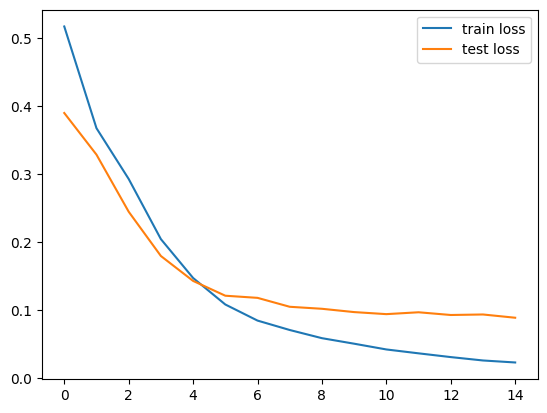

In [30]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [31]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9971, Test acc: 0.9750
